In [1]:
"""import os
import shutil

os.makedirs('/root/.config/kaggle', exist_ok=True)
shutil.copy('/content/drive/My Drive/kaggle.json', '/root/.config/kaggle/kaggle.json')

os.chmod('/root/.config/kaggle/kaggle.json', 600)
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()"""

"import os\nimport shutil\n\nos.makedirs('/root/.config/kaggle', exist_ok=True)\nshutil.copy('/content/drive/My Drive/kaggle.json', '/root/.config/kaggle/kaggle.json')\n\nos.chmod('/root/.config/kaggle/kaggle.json', 600)\nfrom kaggle.api.kaggle_api_extended import KaggleApi\n\napi = KaggleApi()\napi.authenticate()"

In [2]:
"""xrays_tot = "nih-chest-xrays/data"
download_path = "/content/drive/My Drive/xrays_tot"

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(xrays_tot, path=download_path, unzip=True)

print(f"Dataset downloaded and saved to: {download_path}")"""

'xrays_tot = "nih-chest-xrays/data"\ndownload_path = "/content/drive/My Drive/xrays_tot"\n\nos.makedirs(download_path, exist_ok=True)\napi.dataset_download_files(xrays_tot, path=download_path, unzip=True)\n\nprint(f"Dataset downloaded and saved to: {download_path}")'

# Chest X-Ray Classification Project: Leveraging Deep Learning for Medical Image Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pli
import seaborn as sns
import os
import tensorflow as tf
from PIL import Image
import torch
from torch import nn
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive
from torchvision import transforms
from torch.utils.data import ConcatDataset
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import random
import torch

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = "/content/drive/My Drive/xrays_tot"
labels_file = os.path.join(base_path, "Data_Entry_2017.csv")

labels_df = pd.read_csv(labels_file)
image_folders = [f"images_{str(i).zfill(3)}" for i in range(1, 11)]

data_tot = []
for _, row in labels_df.iterrows():
    image_name = row["Image Index"]
    labels = row["Finding Labels"].split('|')

    image_path = None
    for folder in image_folders:
        potential_path = os.path.join(base_path, folder, "images", image_name)
        if os.path.exists(potential_path):
            image_path = potential_path
            break

    if image_path:
        data_tot.append({'image_path': image_path, 'labels': labels})

print(data_tot[:5])

[{'image_path': '/content/drive/My Drive/xrays_tot/images_001/images/00000001_000.png', 'labels': ['Cardiomegaly']}, {'image_path': '/content/drive/My Drive/xrays_tot/images_001/images/00000001_001.png', 'labels': ['Cardiomegaly', 'Emphysema']}, {'image_path': '/content/drive/My Drive/xrays_tot/images_001/images/00000001_002.png', 'labels': ['Cardiomegaly', 'Effusion']}, {'image_path': '/content/drive/My Drive/xrays_tot/images_001/images/00000002_000.png', 'labels': ['No Finding']}, {'image_path': '/content/drive/My Drive/xrays_tot/images_001/images/00000003_000.png', 'labels': ['Hernia']}]


In [6]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [7]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [8]:
labels_df.shape

(112120, 12)

In [9]:
labels_df['Finding Labels'].value_counts()

,count
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
...,...
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia,1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax,1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax,1


In [10]:
num_class_1 = sum(["Infiltration" in r["labels"] for r in data_tot])
num_class_0 = sum(["Infiltration" not in r["labels"] for r in data_tot])

print(f"Class 1 (Infiltration): {num_class_1}")
print(f"Class 0 (Not Infiltration): {num_class_0}")

Class 1 (Infiltration): 15845
Class 0 (Not Infiltration): 75599


In [43]:
class_1_data = [r for r in data_tot if "Infiltration" in r["labels"]]
class_0_data = [r for r in data_tot if "Infiltration" not in r["labels"]]

random.seed(42)
class_1_sampled = random.sample(class_1_data, 3500)
class_0_sampled = random.sample(class_0_data, 4500)

balanced_data = class_0_sampled + class_1_sampled

new_num_class_1 = sum(["Infiltration" in r["labels"] for r in balanced_data])
new_num_class_0 = sum(["Infiltration" not in r["labels"] for r in balanced_data])

print(f"New Class 1 (Infiltration): {new_num_class_1}")
print(f"New Class 0 (Not Infiltration): {new_num_class_0}")

New Class 1 (Infiltration): 3500
New Class 0 (Not Infiltration): 4500


In [44]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [45]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# TensorFlow Keras / MobileNetV2

In [46]:
def preprocess_item(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    return image, label

paths = [item['image_path'] for item in balanced_data]
labels = [1 if "Infiltration" in item["labels"] else 0 for item in balanced_data]

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
# Maps the preprocess_item function over the dataset with parallel processing to improve speed
# (num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda x, y: preprocess_item(x, y), num_parallel_calls=tf.data.AUTOTUNE)

dataset_nobatch = dataset

In [47]:
# Shuffle to improve your workout
dataset = dataset.shuffle(buffer_size=3000)

# Batch creation. Prefetch to load next batch in parallel
dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [48]:
for images, labels in dataset.take(1):
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Batch shape: (64, 224, 224, 3), Labels shape: (64,)


In [49]:
total_images = 0
for images, labels in dataset:
   total_images += images.shape[0]

print(f"Total_number_of: {total_images}")

Total_number_of: 8000


**Model Description**  
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights frozen (trainable=False).

Key components include:  
- GlobalAveragePooling2D.   
- A fully connected layer with 64 units and ReLU activation.
- An output layer with 1 unit and sigmoid activation for binary classification.  
- Optimizer: Adam, configured with a learning rate of 0.001.
- Loss function: Binary crossentropy, suitable for binary classification tasks.
- Metric: Accuracy, to evaluate the model’s performance.

In [50]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# the pre-trained model uses weights derived from training on ImageNet
base_model.trainable = False

model_tf = tf.keras.Sequential([base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [51]:
model_tf.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [52]:
dataset = dataset.shuffle(buffer_size=len(balanced_data))
dataset_size = len(dataset)

test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = dataset.take(test_size)  # Top 20% for the test
train_set = dataset.skip(test_size)  # Remaining 80% for training

In [53]:
print(f"Dataset (batch): {dataset_size}")
print(f"Test set (batch): {test_size}")
print(f"Training set (batch): {train_size}")

Dataset (batch): 125
Test set (batch): 25
Training set (batch): 100


In [54]:
history = model_tf.fit(train_set, epochs=3)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.5335 - loss: 0.7655
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.5909 - loss: 0.6904
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.6766 - loss: 0.6021


In [55]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.6163 - loss: 0.6468
Test Loss: 0.657154381275177, Test Accuracy: 0.6087499856948853


In [56]:
y_true = []
y_pred = []
for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
              precision    recall  f1-score   sup

This is due to the imbalance of the dataset the model almost always predicts 0, largely failing to detect most of the positive cases.  
**Precision for Class 1**:  
0.39 indicates that when the model predicts "Infiltration", it is correct 39% of the time.  
**Recall for Class 1**:  
0.14 indicates that the model only identifies 14% of actual "Infiltration" cases.

# Pytorch / MobileNetV2



In [57]:
class ChestXRayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image_path']
        label = 1 if "Infiltration" in self.data[idx]['labels'] else 0
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

dataset_pytorch = ChestXRayDataset(balanced_data, transform=transform)
train_size = int(0.8 * len(dataset_pytorch))
test_size = len(dataset_pytorch) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset_pytorch, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Model Description**  
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights retained from the pretraining.

Key components include:
  
- A linear classifier, replacing the original output layer, with a single output logit for binary classification.
- Loss function: BCEWithLogitsLoss, which combines sigmoid activation and binary crossentropy for stable handling of logits.
- Optimizer: Adam, configured with a learning rate of 0.001.

In [59]:
# Pre-trained model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
# Training
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/3, Loss: 0.6723
Epoch 2/3, Loss: 0.6339
Epoch 3/3, Loss: 0.6195


In [61]:
# Validation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Test Classification Report:")
print(classification_report(y_true, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       905
           1       0.54      0.70      0.61       695

    accuracy                           0.61      1600
   macro avg       0.62      0.62      0.61      1600
weighted avg       0.63      0.61      0.61      1600



The results highlight the significant impact of dataset imbalance on the model's performance.

- **Precision for Class 1**:  
  With a precision of 0.33, the model is correct 33% of times when it predicts class 1.

- **Recall for Class 1**:  
  A recall of 0.01 indicates that the model correctly identifies only 1% of actual positive cases.

The overall accuracy (83%) and the high performance on **class 0** are driven by the dataset imbalance, as the majority of the samples belong to this class.

# Data Augmentation and Balancing for Class 1  
This section implements data augmentation techniques to balance the dataset and improve the model's ability to detect positive cases (Class 1 - "Infiltration"). Augmentation is applied selectively to Class 1 images, and the augmented data is combined with the original dataset for training.

## TensorFlow Keras / MobileNetV2 (with Data Augmentation)

In [62]:
class_1_sampled_to_augment = random.sample(class_1_sampled, 1000)
print(len(class_1_sampled_to_augment))

1000


In [63]:
def augment_image(image):
    # Augmentation operations
    image = tf.image.random_flip_left_right(image)  # Horizontal Flip
    image = tf.image.random_flip_up_down(image)    # Vertical Flip
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # Random rotation
    return image

# Preprocessing and augmentation function
def preprocess_and_augment(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    image = augment_image(image)
    return image, label

class_1_paths_to_augment = [item['image_path'] for item in class_1_sampled_to_augment]
class_1_labels_to_augment = [1] * len(class_1_paths_to_augment)
class_1_sampled_to_augment = tf.data.Dataset.from_tensor_slices((class_1_paths_to_augment, class_1_labels_to_augment))

class_1_sampled_augmented = class_1_sampled_to_augment.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)

In [64]:
augmented_count = sum(1 for _ in class_1_sampled_augmented)
print(f"Number of augmented samples: {augmented_count}")

Number of augmented samples: 1000


In [65]:
final_dataset = dataset_nobatch.concatenate(class_1_sampled_augmented)
print(len(final_dataset))

9000


In [66]:
# Apply shuffle and batching to the combined dataset
final_dataset = final_dataset.shuffle(buffer_size=len(final_dataset))
final_dataset = final_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [67]:
dataset_size = len(final_dataset)
test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = final_dataset.take(test_size)  # Top 20% for the test
train_set = final_dataset.skip(test_size)  # Remaining 80% for training

In [68]:
print(f"Dataset totale: {dataset_size}")
print(f"Test set: {test_size}")
print(f"Training set: {train_size}")

Dataset totale: 141
Test set: 28
Training set: 113


In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_tf.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
history = model_tf.fit(train_set, epochs=3)

Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.6752 - loss: 0.5979
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.6757 - loss: 0.5704
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.6841 - loss: 0.5634


In [71]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.7027 - loss: 0.5382
Test Loss: 0.5406719446182251, Test Accuracy: 0.7047991156578064


In [72]:
y_true = []
y_pred = []

for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

thresholds = [0.4, 0.5]
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"Classification report for threshold = {threshold}")
    print(classification_report(y_true, y_pred_class))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━

The results demonstrate the impact of varying thresholds on the model's performance and its handling of class imbalance. At a low threshold of 0.3, the model achieves high recall for Class 1 (74%) but at the cost of low precision (20%), resulting in many false positives. Increasing the threshold to 0.4 improves overall balance, with Class 1 recall dropping to 57% but precision rising to 23%. At the standard threshold of 0.5, precision for Class 1 improves further (27%), but recall decreases to 44%. These results highlight the trade-off between precision and recall for Class 1 and underscore the need for careful threshold selection and strategies to address dataset imbalance.

## Pytorch / MobileNetV2 (with Data Augmentation)


In [80]:
# Transformations with Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flip
    transforms.RandomVerticalFlip(p=0.5),    # Vertical Flip
    transforms.RandomRotation(degrees=90),   # Random rotation within 45°
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# Basic transformations (without augmentation)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# Original dataset with basic transformations
base_dataset = ChestXRayDataset(balanced_data, transform=base_transforms)

In [81]:
# Dataset augmented for class 1 only
class_1_sampled_to_augment = random.sample(class_1_sampled, 1000)
class_1_data_augmented = ChestXRayDataset(class_1_sampled_to_augment, transform=augmentation_transforms)
print(len(class_1_data_augmented))

# Combine the original and augmented dataset
combined_dataset = ConcatDataset([base_dataset, class_1_data_augmented])
print(len(combined_dataset))

1000
9000


In [82]:
# DataLoader
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

______________________________________________________________________________________________________________________________________


--- Training with Learning Rate: 0.01 ---
Epoch 1/3, Training Loss: 0.6636, Test Loss: 0.6454
Epoch 2/3, Training Loss: 0.6235, Test Loss: 0.6202
Epoch 3/3, Training Loss: 0.6047, Test Loss: 0.6335
Classification report for threshold = 0.4
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       910
           1       0.63      0.64      0.64       890

    accuracy                           0.64      1800
   macro avg       0.64      0.64      0.64      1800
weighted avg       0.64      0.64      0.64      1800

Classification report for threshold = 0.5
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       910
           1       0.71      0.51      0.60       890

    accuracy                           0.66      1800
   macro avg       0.67      0.66      0.65      1800
weighted avg       0.67      0.66      0.65      1800



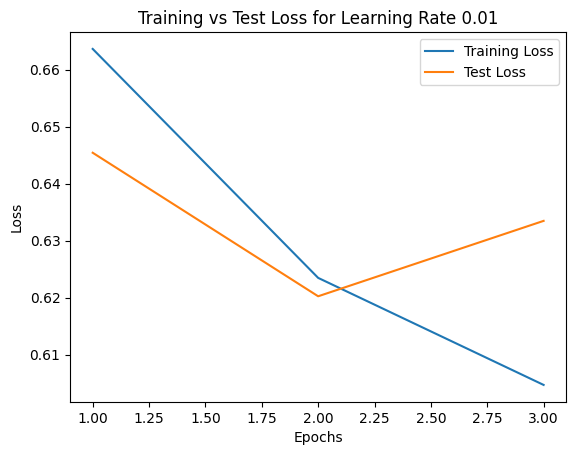


--- Training with Learning Rate: 0.001 ---
Epoch 1/3, Training Loss: 0.6420, Test Loss: 0.6389
Epoch 2/3, Training Loss: 0.6137, Test Loss: 0.6183
Epoch 3/3, Training Loss: 0.6068, Test Loss: 0.6154
Classification report for threshold = 0.4
              precision    recall  f1-score   support

           0       0.69      0.40      0.51       910
           1       0.57      0.82      0.67       890

    accuracy                           0.61      1800
   macro avg       0.63      0.61      0.59      1800
weighted avg       0.63      0.61      0.59      1800

Classification report for threshold = 0.5
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       910
           1       0.65      0.65      0.65       890

    accuracy                           0.66      1800
   macro avg       0.66      0.66      0.66      1800
weighted avg       0.66      0.66      0.66      1800



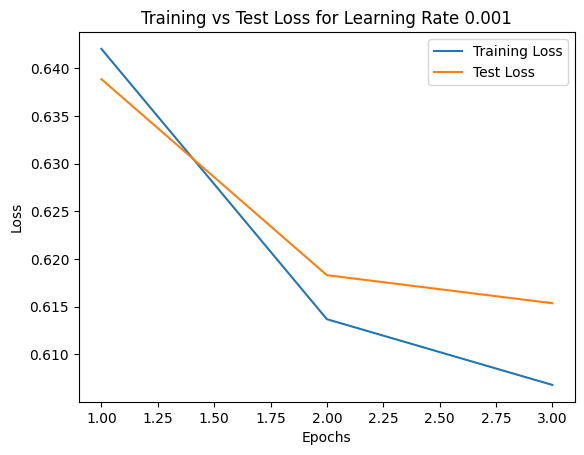

In [83]:
# Define a function to calculate test loss
def evaluate_model_loss(model, criterion, data_loader, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(data_loader)

# Update train_and_evaluate function
def train_and_evaluate(model, optimizer, learning_rate, num_epochs, train_loader, test_loader, thresholds=[0.4, 0.5]):
    print(f"\n--- Training with Learning Rate: {learning_rate} ---")
    training_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss
        training_loss = running_loss / len(train_loader)
        training_losses.append(training_loss)

        # Calculate test loss
        test_loss = evaluate_model_loss(model, criterion, test_loader, device)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics for each threshold
    for threshold in thresholds:
        y_pred_class = (y_pred > threshold).astype(int)
        print(f"Classification report for threshold = {threshold}")
        print(classification_report(y_true, y_pred_class))

    # Return metrics and losses for analysis
    return y_true, y_pred, training_losses, test_losses

# Initialize models, optimizers, and train
results = {}
learning_rates = [0.01, 0.001]

for lr in learning_rates:
    # Clone the base model
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.last_channel, 1)
    model = model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # Train and evaluate
    y_true, y_pred, training_losses, test_losses = train_and_evaluate(model, optimizer, lr, num_epochs=3, train_loader=train_loader, test_loader=test_loader)

    # Store results for further analysis
    results[lr] = (y_true, y_pred, training_losses, test_losses)

    # Plot Training vs Test Loss for this learning rate
    plt.figure()
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs Test Loss for Learning Rate {lr}")
    plt.legend()
    plt.show()

In [84]:
y_true, y_pred = results[0.01][:2]
print(y_true, y_pred)

[0 1 1 ... 0 0 0] [0.5336489  0.3371043  0.30929422 ... 0.2958738  0.2623158  0.25114608]


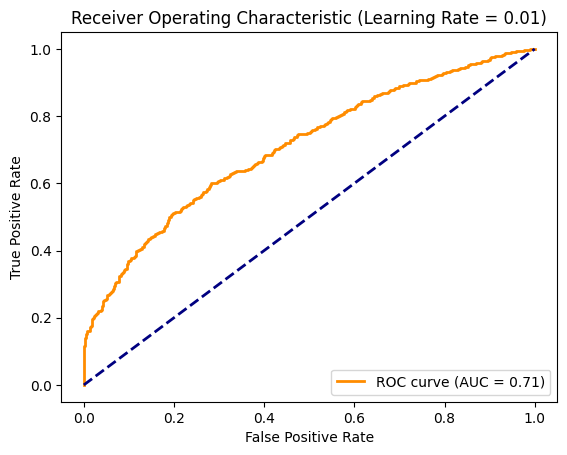

In [85]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Learning Rate = 0.01)')
plt.legend(loc='lower right')
plt.show()

Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 0.80, FPR: 0.02, TPR: 0.18
Threshold: 0.76, FPR: 0.04, TPR: 0.22
Threshold: 0.70, FPR: 0.06, TPR: 0.28
Threshold: 0.66, FPR: 0.08, TPR: 0.32
Threshold: 0.62, FPR: 0.10, TPR: 0.37
Threshold: 0.60, FPR: 0.12, TPR: 0.40
Threshold: 0.56, FPR: 0.15, TPR: 0.43
Threshold: 0.53, FPR: 0.18, TPR: 0.47
Threshold: 0.50, FPR: 0.20, TPR: 0.51
Threshold: 0.48, FPR: 0.23, TPR: 0.53
Threshold: 0.46, FPR: 0.26, TPR: 0.56
Threshold: 0.44, FPR: 0.28, TPR: 0.60
Threshold: 0.41, FPR: 0.33, TPR: 0.63
Threshold: 0.40, FPR: 0.37, TPR: 0.64
Threshold: 0.38, FPR: 0.39, TPR: 0.66
Threshold: 0.36, FPR: 0.42, TPR: 0.70
Threshold: 0.34, FPR: 0.46, TPR: 0.73
Threshold: 0.32, FPR: 0.50, TPR: 0.76
Threshold: 0.30, FPR: 0.54, TPR: 0.78
Threshold: 0.29, FPR: 0.57, TPR: 0.80
Threshold: 0.27, FPR: 0.60, TPR: 0.82
Threshold: 0.26, FPR: 0.63, TPR: 0.85
Threshold: 0.24, FPR: 0.67, TPR: 0.87
Threshold: 0.23, FPR: 0.71, TPR: 0.89
Threshold: 0.20, FPR: 0.78, TPR: 0.92
Threshold: 0.

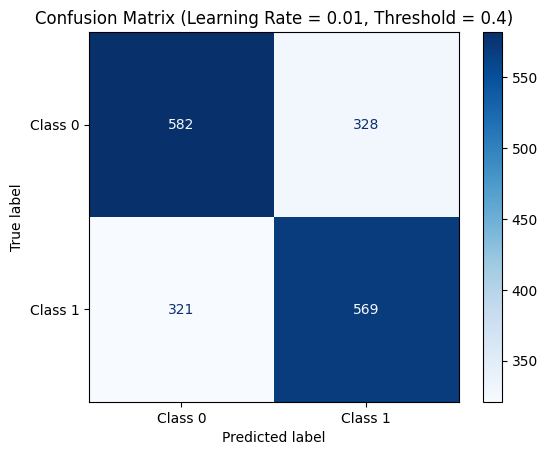

In [86]:
for i, (thr, fp, tp) in enumerate(zip(thresholds_roc, fpr, tpr)):
    if i % 25 == 0:  # Print key thresholds
        print(f"Threshold: {thr:.2f}, FPR: {fp:.2f}, TPR: {tp:.2f}")

# Confusion Matrix for threshold = 0.4
threshold = 0.4
y_pred_class = (y_pred > threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Learning Rate = 0.01, Threshold = 0.4)')
plt.show()

The model demonstrates a good balance in recognizing **Class 0**, with a low false positive rate and high accuracy (87.3%). However, its performance on **Class 1** is disappointing, as it correctly identifies only about 50% of positive cases while misclassifying the other half as false negatives. Although it might seem like the model is "guessing" on **Class 1**, it is not entirely equivalent to flipping a coin, given its strong performance on **Class 0**. That said, if the primary goal is to identify **Class 1**, the model is far from reliable. This version, while the best I have been able to achieve with the current dataset and methods, is not suitable for practical applications. Significant improvements, particularly in addressing dataset imbalance and optimizing performance on **Class 1**, are required.